# Beyond the Numbers: Exploratory Data Analysis of African School Dropout Patterns

**UCU MSc Data Science - Data Visualization Exam | Question 6**

Comprehensive EDA of school dropout risks in Sub-Saharan Africa using World Bank Education Statistics.

## Objectives
1. Explore enrollment, completion, and dropout patterns
2. Analyze gender disparities and regional variations
3. Identify key risk factors and vulnerable populations
4. Generate insights for predictive modeling
5. Create compelling visualizations for policy makers

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Initial Exploration

In [3]:
# Load the collected education data
try:
    # Try to load existing processed data
    import glob
    feature_files = glob.glob('data/processed/dropout_risk_features_*.csv')
    raw_files = glob.glob('data/raw/african_education_raw_*.csv')
    
    if feature_files and raw_files:
        # Load most recent files
        features_df = pd.read_csv(sorted(feature_files)[-1])
        raw_df = pd.read_csv(sorted(raw_files)[-1])
        print(f"Loaded existing data:")
        print(f"- Raw data: {len(raw_df):,} records")
        print(f"- Feature data: {len(features_df):,} records")
    else:
        print("No existing data found. Running data collection...")
        exec(open('data_collection.py').read())
        # Reload after collection
        feature_files = glob.glob('data/processed/dropout_risk_features_*.csv')
        raw_files = glob.glob('data/raw/african_education_raw_*.csv')
        features_df = pd.read_csv(sorted(feature_files)[-1])
        raw_df = pd.read_csv(sorted(raw_files)[-1])
        
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please run data_collection.py first")

Loaded existing data:
- Raw data: 5,600 records
- Feature data: 405 records


In [4]:
# Dataset overview
print("=== DATASET OVERVIEW ===")
print(f"Raw Data Shape: {raw_df.shape}")
print(f"Feature Data Shape: {features_df.shape}")
print(f"Countries: {len(raw_df['country_code'].unique())}")
print(f"Indicators: {len(raw_df['indicator_code'].unique())}")
print(f"Years: {raw_df['year'].min()} - {raw_df['year'].max()}")

print("\n=== COUNTRIES INCLUDED ===")
countries = raw_df[['country_code', 'country_name']].drop_duplicates().sort_values('country_name')
for _, row in countries.iterrows():
    print(f"{row['country_code']}: {row['country_name']}")

=== DATASET OVERVIEW ===
Raw Data Shape: (5600, 7)
Feature Data Shape: (405, 37)
Countries: 27
Indicators: 28
Years: 2010 - 2024

=== COUNTRIES INCLUDED ===
AGO: Angola
BWA: Botswana
BFA: Burkina Faso
BDI: Burundi
CMR: Cameroon
CAF: Central African Republic
TCD: Chad
COD: Congo, Dem. Rep.
SWZ: Eswatini
ETH: Ethiopia
GHA: Ghana
KEN: Kenya
LSO: Lesotho
MDG: Madagascar
MWI: Malawi
MLI: Mali
MOZ: Mozambique
NAM: Namibia
NER: Niger
NGA: Nigeria
RWA: Rwanda
SEN: Senegal
ZAF: South Africa
TZA: Tanzania
UGA: Uganda
ZMB: Zambia
ZWE: Zimbabwe


## 2. Data Quality Assessment

=== DATA COMPLETENESS BY INDICATOR ===
                   Total_Records  Non_Null_Values  Countries_Covered  \
indicator_code                                                         
NY.GDP.PCAP.CD               403              403                 27   
SE.ADT.LITR.FE.ZS            104              104                 27   
SE.ADT.LITR.MA.ZS            103              103                 27   
SE.ADT.LITR.ZS               103              103                 27   
SE.PRM.CMPT.FE.ZS            234              234                 27   
SE.PRM.CMPT.MA.ZS            235              235                 27   
SE.PRM.CMPT.ZS               237              237                 27   
SE.PRM.DURS                  378              378                 27   
SE.PRM.NENR                  124              124                 25   
SE.PRM.NENR.FE               112              112                 23   

                   Completeness_%  
indicator_code                     
NY.GDP.PCAP.CD          

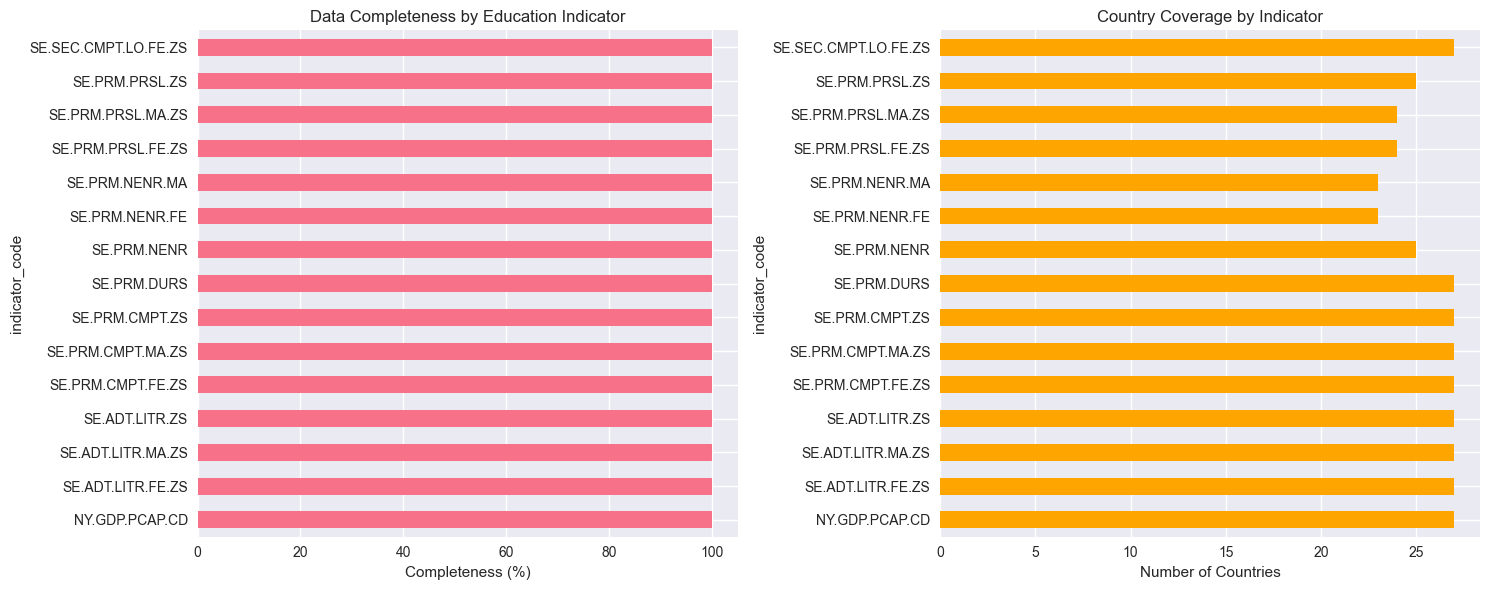

In [7]:
# Data completeness analysis
print("=== DATA COMPLETENESS BY INDICATOR ===")
completeness = raw_df.groupby('indicator_code').agg({
    'value': ['count', lambda x: x.notna().sum()],
    'country_code': 'nunique'
}).round(2)

completeness.columns = ['Total_Records', 'Non_Null_Values', 'Countries_Covered']
completeness['Completeness_%'] = (completeness['Non_Null_Values'] / completeness['Total_Records'] * 100).round(1)
completeness = completeness.sort_values('Completeness_%', ascending=False)

print(completeness.head(10))

# Visualize data completeness
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Completeness by indicator
completeness.head(15)['Completeness_%'].plot(kind='barh', ax=ax1)
ax1.set_title('Data Completeness by Education Indicator')
ax1.set_xlabel('Completeness (%)')

# Countries coverage
completeness.head(15)['Countries_Covered'].plot(kind='barh', ax=ax2, color='orange')
ax2.set_title('Country Coverage by Indicator')
ax2.set_xlabel('Number of Countries')

plt.tight_layout()
plt.show()

## 3. Regional and Country-Level Analysis

In [8]:
# Define regional groupings for Sub-Saharan Africa
regional_groups = {
    'East Africa': ['UGA', 'KEN', 'TZA', 'RWA', 'ETH', 'BDI'],
    'West Africa': ['GHA', 'NGA', 'SEN', 'MLI', 'BFA', 'NER'],
    'Central Africa': ['CMR', 'CAF', 'COD', 'TCD', 'AGO'],
    'Southern Africa': ['ZAF', 'BWA', 'ZWE', 'ZMB', 'MWI', 'MOZ', 'MDG', 'NAM', 'LSO', 'SWZ']
}

# Add regional classification to features dataset
def get_region(country_code):
    for region, countries in regional_groups.items():
        if country_code in countries:
            return region
    return 'Other'

features_df['region'] = features_df['country_code'].apply(get_region)

print("=== REGIONAL DISTRIBUTION ===")
print(features_df['region'].value_counts())

=== REGIONAL DISTRIBUTION ===
region
Southern Africa    150
East Africa         90
West Africa         90
Central Africa      75
Name: count, dtype: int64


In [9]:
# Primary enrollment analysis by region
if 'SE.PRM.NENR' in features_df.columns:
    fig = px.box(
        features_df.dropna(subset=['SE.PRM.NENR']), 
        x='region', 
        y='SE.PRM.NENR',
        title='Primary School Net Enrollment Rate by Region',
        labels={'SE.PRM.NENR': 'Primary Enrollment Rate (%)', 'region': 'Region'}
    )
    fig.update_layout(height=500)
    fig.show()

# Secondary enrollment analysis
if 'SE.SEC.NENR' in features_df.columns:
    fig = px.box(
        features_df.dropna(subset=['SE.SEC.NENR']), 
        x='region', 
        y='SE.SEC.NENR',
        title='Secondary School Net Enrollment Rate by Region',
        labels={'SE.SEC.NENR': 'Secondary Enrollment Rate (%)', 'region': 'Region'}
    )
    fig.update_layout(height=500)
    fig.show()

**Key Findings: Primary School Enrollment Analysis**

**Best Performing Region:**

East Africa shows the highest median enrollment (~87%) with relatively consistent performance across countries

**Regional Performance:**
Southern Africa: High median (~88%) but with more variation between countries
Central Africa: Moderate performance (~78% median) with wide variation (62-94%)
West Africa: Lowest and most concerning performance (~67% median) with the widest range (54-89%)

**Key Insights:**
West Africa faces the biggest challenge - lowest enrollment rates and highest inequality between countries
East Africa demonstrates consistency - not only high rates but also more uniform access across the region
All regions show significant within-region disparities - indicating that even within the same geographical area, some countries are performing much better than others

**Policy Implications:**
West African countries need urgent intervention to improve primary school access
Best practices from high-performing East African countries could be shared regionally
The wide variations within regions suggest country-specific factors (governance, resources, conflict) play a major role beyond geographical location

**Key Findings: Secondary School Enrollment Analysis**

Southern Africa leads in secondary enrollment despite having some very low-performing countries (outliers at ~17%)
Central Africa struggles most - lowest median AND most countries clustered in the 15-25% range
Dramatic regional differences: Southern Africa's median is nearly 2x higher than Central Africa's

**High-performing outliers:** Southern Africa has countries reaching 72% and 90% - showing what's possible with the right policies
East Africa's surprising decline: From being the primary education leader to third place in secondary education

**Key Insight:** The transition from primary to secondary education is where the biggest educational crisis occurs across all regions, but Southern African countries are handling this transition better than others, despite still losing most students between levels.

## 4. Gender Disparity Analysis

=== PROCESSING PRIMARY ENROLLMENT ===
Valid data points across all years: 112
Sample data:
   country_code  year  SE.PRM.NENR.FE  SE.PRM.NENR.MA
0           AGO  2010        68.62343        83.07248
1           AGO  2011        67.27698        88.90347
15          BDI  2010        96.42535        94.32479
22          BDI  2017        96.35943        93.40181
23          BDI  2018        94.09198        91.52725
Female data range: (np.float64(47.99076), np.float64(99.47912))
Male data range: (np.float64(59.12628), np.float64(98.67048))
Average gender parity ratio: 0.960
Countries with near gender parity (>=0.95): 70/112

=== PROCESSING SECONDARY ENROLLMENT ===
Valid data points across all years: 95
Sample data:
   country_code  year  SE.SEC.NENR.FE  SE.SEC.NENR.MA
0           AGO  2010        10.07569        12.52422
15          BDI  2010        13.68895        16.67038
16          BDI  2011        15.45501        18.32535
17          BDI  2012        17.44259        19.40508
18        

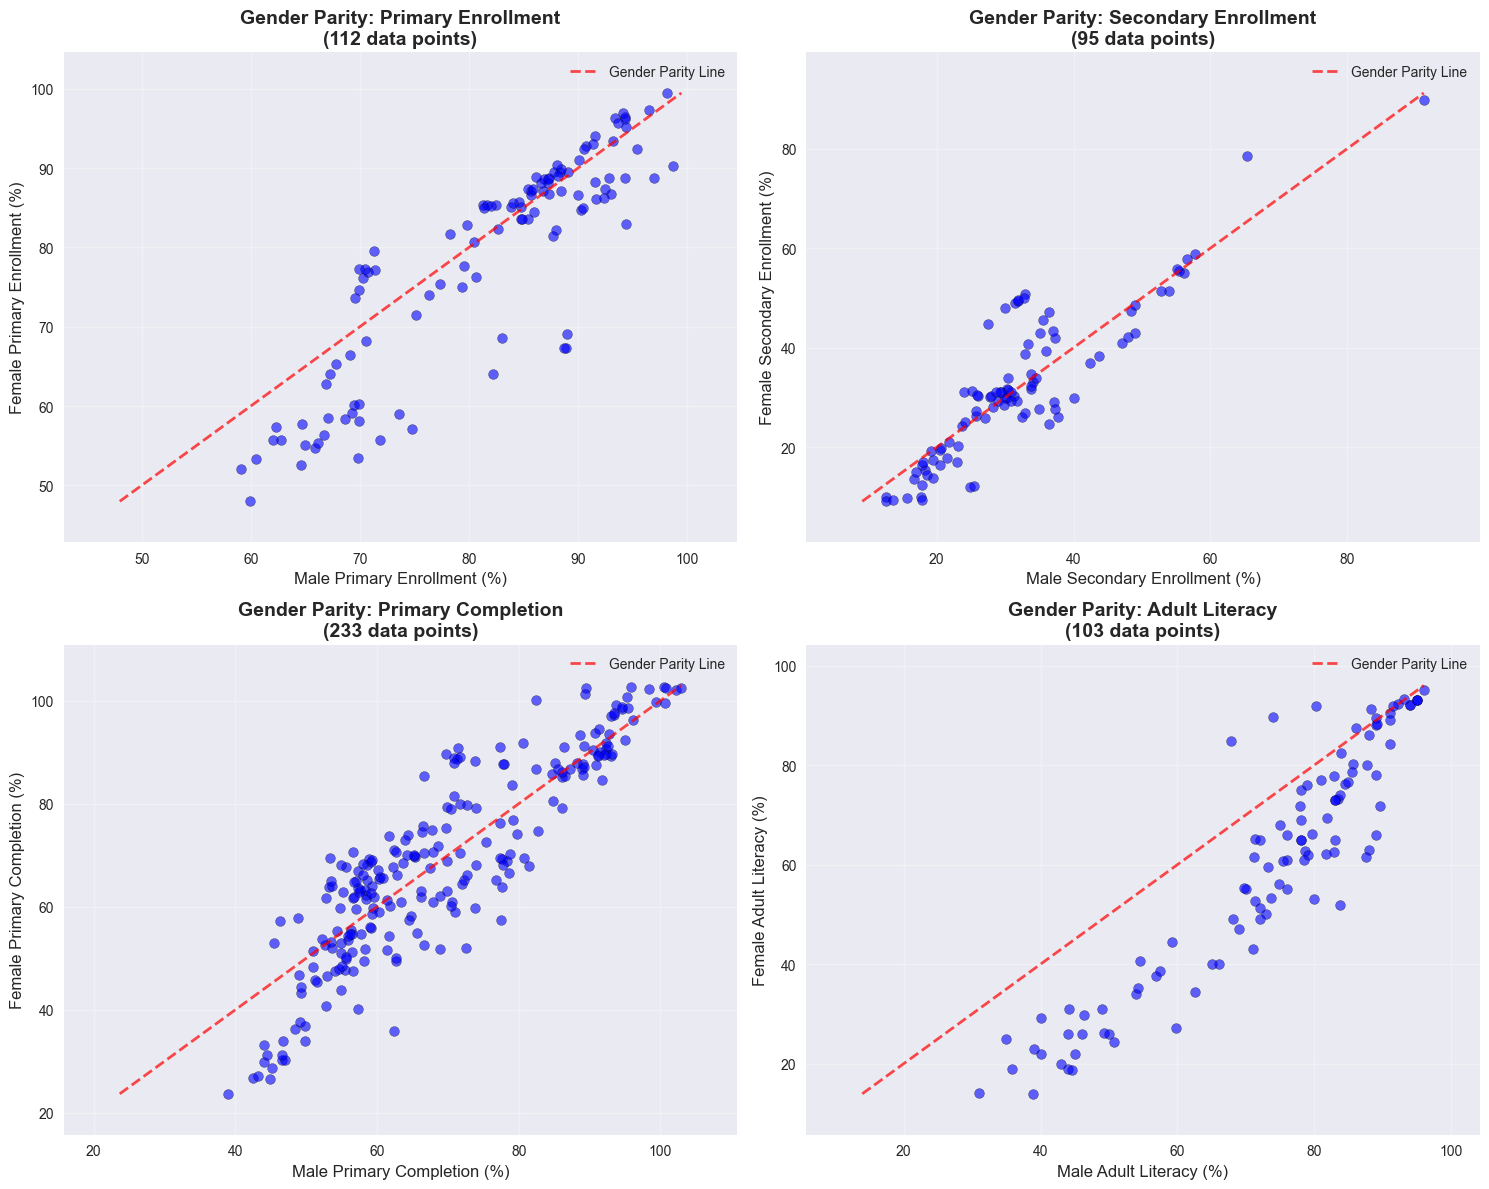

=== GENDER PARITY SUMMARY ===

Primary Enrollment:
  Data points: 112
  Average parity ratio: 0.960
  Countries with female advantage (>1.0): 51
  Countries with male advantage (<1.0): 61
  Countries with near parity (0.95-1.05): 61

Secondary Enrollment:
  Data points: 95
  Average parity ratio: 0.987
  Countries with female advantage (>1.0): 40
  Countries with male advantage (<1.0): 55
  Countries with near parity (0.95-1.05): 29

Primary Completion:
  Data points: 233
  Average parity ratio: 0.989
  Countries with female advantage (>1.0): 109
  Countries with male advantage (<1.0): 124
  Countries with near parity (0.95-1.05): 74

Adult Literacy:
  Data points: 103
  Average parity ratio: 0.790
  Countries with female advantage (>1.0): 9
  Countries with male advantage (<1.0): 94
  Countries with near parity (0.95-1.05): 21


In [13]:
gender_indicators = {
    'Primary Enrollment': ['SE.PRM.NENR.FE', 'SE.PRM.NENR.MA'],
    'Secondary Enrollment': ['SE.SEC.NENR.FE', 'SE.SEC.NENR.MA'],
    'Primary Completion': ['SE.PRM.CMPT.FE.ZS', 'SE.PRM.CMPT.MA.ZS'],
    'Adult Literacy': ['SE.ADT.LITR.FE.ZS', 'SE.ADT.LITR.MA.ZS']
}

# Create gender comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (indicator_name, (female_code, male_code)) in enumerate(gender_indicators.items()):
    print(f"=== PROCESSING {indicator_name.upper()} ===")
    
    # Check if columns exist
    if female_code in features_df.columns and male_code in features_df.columns:
        # Instead of getting latest year, get all valid data points
        valid_data = features_df.dropna(subset=[female_code, male_code])
        print(f"Valid data points across all years: {len(valid_data)}")
        
        if len(valid_data) > 0:
            # Show sample data
            print("Sample data:")
            print(valid_data[['country_code', 'year', female_code, male_code]].head())
            
            # Check data ranges
            female_range = (valid_data[female_code].min(), valid_data[female_code].max())
            male_range = (valid_data[male_code].min(), valid_data[male_code].max())
            print(f"Female data range: {female_range}")
            print(f"Male data range: {male_range}")
            
            # Create scatter plot
            scatter = axes[i].scatter(valid_data[male_code], valid_data[female_code], 
                                    alpha=0.6, s=50, color='blue', edgecolors='black', linewidth=0.3)
            
            # Add parity line
            min_val = min(valid_data[male_code].min(), valid_data[female_code].min())
            max_val = max(valid_data[male_code].max(), valid_data[female_code].max())
            axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2, label='Gender Parity Line')
            
            # Set labels and title
            axes[i].set_xlabel(f'Male {indicator_name} (%)', fontsize=12)
            axes[i].set_ylabel(f'Female {indicator_name} (%)', fontsize=12)
            axes[i].set_title(f'Gender Parity: {indicator_name}\n({len(valid_data)} data points)', fontsize=14, fontweight='bold')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            
            # Set axis limits with padding
            padding = (max_val - min_val) * 0.1 if max_val != min_val else 5
            axes[i].set_xlim(min_val - padding, max_val + padding)
            axes[i].set_ylim(min_val - padding, max_val + padding)
            
            # Calculate and display gender parity statistics
            parity_ratio = valid_data[female_code] / valid_data[male_code]
            avg_parity = parity_ratio.mean()
            countries_with_parity = (parity_ratio >= 0.95).sum()  # Within 5% of parity
            
            print(f"Average gender parity ratio: {avg_parity:.3f}")
            print(f"Countries with near gender parity (>=0.95): {countries_with_parity}/{len(valid_data)}")
            
        else:
            axes[i].text(0.5, 0.5, f'No valid data available\nfor {indicator_name}', 
                        ha='center', va='center', transform=axes[i].transAxes, fontsize=12)
            axes[i].set_title(f'Gender Parity: {indicator_name}', fontsize=14)
            print(f"No valid data for {indicator_name}")
    else:
        axes[i].text(0.5, 0.5, f'Missing columns\nfor {indicator_name}', 
                    ha='center', va='center', transform=axes[i].transAxes, fontsize=12)
        axes[i].set_title(f'Gender Parity: {indicator_name}', fontsize=14)
        print(f"Missing columns for {indicator_name}")
    
    print()  # Empty line for readability

plt.tight_layout()
plt.show()

# Summary statistics for gender parity
print("=== GENDER PARITY SUMMARY ===")
for indicator_name, (female_code, male_code) in gender_indicators.items():
    if female_code in features_df.columns and male_code in features_df.columns:
        valid_data = features_df.dropna(subset=[female_code, male_code])
        if len(valid_data) > 0:
            parity_ratio = valid_data[female_code] / valid_data[male_code]
            print(f"\n{indicator_name}:")
            print(f"  Data points: {len(valid_data)}")
            print(f"  Average parity ratio: {parity_ratio.mean():.3f}")
            print(f"  Countries with female advantage (>1.0): {(parity_ratio > 1.0).sum()}")
            print(f"  Countries with male advantage (<1.0): {(parity_ratio < 1.0).sum()}")
            print(f"  Countries with near parity (0.95-1.05): {((parity_ratio >= 0.95) & (parity_ratio <= 1.05)).sum()}")

**Key Findings:**

1. **Primary Enrollment (112 data points)**

Average parity ratio: 0.960 - Nearly equal, with slight male advantage
61 countries with near parity (0.95-1.05) - Good progress toward equality
Points mostly cluster around the parity line (red dashed line)

2. **Secondary Enrollment (95 data points)**

Average parity ratio: 0.987 - Very close to perfect parity
29 countries with near parity - More variation than primary level
Shows wider spread, indicating more inequality at secondary level

3. **Primary Completion (233 data points)**

Average parity ratio: 0.989 - Nearly equal completion rates
74 countries with near parity - Best performance overall
Most data points cluster tightly around the parity line

4. **Adult Literacy (103 data points)**

Average parity ratio: 0.790 - Significant male advantage
Only 21 countries with near parity - Largest gender gap
Many points fall well below the parity line, showing historical disadvantages for women

## 5. Temporal Trends Analysis

In [17]:
# Check data availability by year and indicator
print("Data availability analysis:")
for indicator in key_indicators:
    if indicator in features_df.columns:
        print(f"\n{indicator_names[indicator]} ({indicator}):")
        
        # Check years with data
        years_with_data = features_df[features_df[indicator].notna()]['year'].unique()
        print(f"Years with data: {sorted(years_with_data)}")
        print(f"Year range: {min(years_with_data)} - {max(years_with_data)}")
        
        # Check data points per year
        yearly_counts = features_df[features_df[indicator].notna()].groupby('year').size()
        print(f"Data points per year: {yearly_counts.to_dict()}")
        
        # Check regional coverage by year
        regional_coverage = features_df[features_df[indicator].notna()].groupby(['year', 'region']).size().unstack(fill_value=0)
        print(f"Regional coverage by year:\n{regional_coverage}")



Data availability analysis:

Primary Enrollment Rate (SE.PRM.NENR):
Years with data: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019)]
Year range: 2010 - 2019
Data points per year: {2010: 16, 2011: 15, 2012: 17, 2013: 15, 2014: 12, 2015: 12, 2016: 12, 2017: 15, 2018: 9, 2019: 1}
Regional coverage by year:
region  Central Africa  East Africa  Southern Africa  West Africa
year                                                             
2010                 2            4                5            5
2011                 4            2                4            5
2012                 2            3                7            5
2013                 1            2                7            5
2014                 1            2                4            5
2015                 2            1                4            5
2016                 2            2                3  

In [18]:
# Time series analysis
for indicator in key_indicators:
    if indicator in features_df.columns:
        # Get all available data
        indicator_data = features_df[features_df[indicator].notna()].copy()
        
        if len(indicator_data) > 0:
            # Calculate regional trends with minimum data requirements
            regional_trends = indicator_data.groupby(['region', 'year']).agg({
                indicator: ['mean', 'count']
            }).reset_index()
            
            # Flatten column names
            regional_trends.columns = ['region', 'year', 'mean_value', 'country_count']
            
            # Filter out years with very few data points (< 2 countries per region)
            regional_trends = regional_trends[regional_trends['country_count'] >= 1]
            
            # Create the plot with markers to show actual data points
            fig = px.line(
                regional_trends, 
                x='year', 
                y='mean_value', 
                color='region',
                title=f'{indicator_names[indicator]} Trends by Region ({regional_trends["year"].min()}-{regional_trends["year"].max()})',
                labels={'mean_value': f'{indicator_names[indicator]} (%)', 'year': 'Year'},
                markers=True,
                hover_data={'country_count': True}
            )
            
            # Add annotations for data quality
            fig.add_annotation(
                text=f"Total observations: {len(indicator_data)} | Years: {len(regional_trends['year'].unique())} | Regions: {len(regional_trends['region'].unique())}",
                xref="paper", yref="paper",
                x=0.02, y=0.98, showarrow=False,
                font=dict(size=10, color="gray"),
                bgcolor="rgba(255,255,255,0.8)"
            )
            
            # Customize layout
            fig.update_layout(
                height=500,
                hovermode='x unified',
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1
                )
            )
            
            # Add grid for better readability
            fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
            fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
            
            fig.show()
            
            # Print detailed summary
            print(f"\n{indicator_names[indicator]} Summary:")
            print(f"   • Data coverage: {regional_trends['year'].min()}-{regional_trends['year'].max()}")
            print(f"   • Total observations: {len(indicator_data)}")
            print(f"   • Peak year: {indicator_data.groupby('year').size().idxmax()} ({indicator_data.groupby('year').size().max()} countries)")
            print(f"   • Recent year: {indicator_data['year'].max()} ({len(indicator_data[indicator_data['year'] == indicator_data['year'].max()])} countries)")


Primary Enrollment Rate Summary:
   • Data coverage: 2010-2019
   • Total observations: 124
   • Peak year: 2012 (17 countries)
   • Recent year: 2019 (1 countries)



Secondary Enrollment Rate Summary:
   • Data coverage: 2010-2019
   • Total observations: 95
   • Peak year: 2015 (15 countries)
   • Recent year: 2019 (1 countries)



Primary Completion Rate Summary:
   • Data coverage: 2010-2023
   • Total observations: 237
   • Peak year: 2012 (23 countries)
   • Recent year: 2023 (14 countries)



Secondary Completion Rate Summary:
   • Data coverage: 2010-2023
   • Total observations: 214
   • Peak year: 2012 (23 countries)
   • Recent year: 2023 (11 countries)


## 6. Dropout Risk Factor Analysis

=== DROPOUT RISK DISTRIBUTION ===
Low Risk: 222 (54.8%)
High Risk: 183 (45.2%)


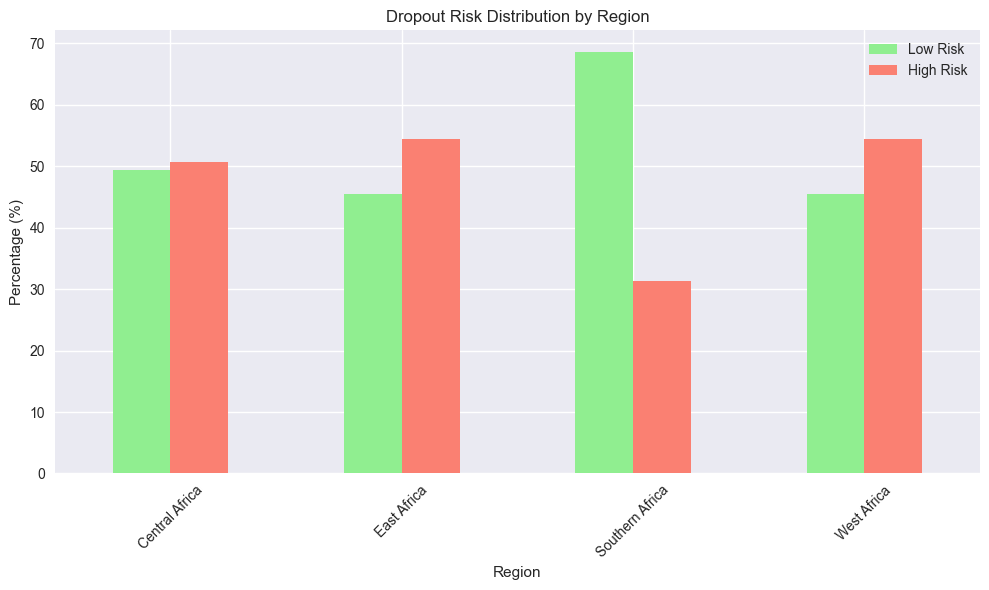

In [20]:
# Analyze dropout risk factors
if 'dropout_risk_high' in features_df.columns:
    print("=== DROPOUT RISK DISTRIBUTION ===")
    risk_dist = features_df['dropout_risk_high'].value_counts()
    print(f"Low Risk: {risk_dist.get(0, 0)} ({risk_dist.get(0, 0)/len(features_df)*100:.1f}%)")
    print(f"High Risk: {risk_dist.get(1, 0)} ({risk_dist.get(1, 0)/len(features_df)*100:.1f}%)")
    
    # Risk by region
    risk_by_region = pd.crosstab(features_df['region'], features_df['dropout_risk_high'], normalize='index') * 100
    
    fig, ax = plt.subplots(figsize=(10, 6))
    risk_by_region.plot(kind='bar', ax=ax, color=['lightgreen', 'salmon'])
    ax.set_title('Dropout Risk Distribution by Region')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel('Region')
    ax.legend(['Low Risk', 'High Risk'])
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

**Dropout Risk Distribution Analysis**

**Overall Distribution:**

54.8% of observations are classified as Low Risk for dropout (222 cases)
45.2% are classified as High Risk for dropout (183 cases)
Regional Patterns: The bar chart reveals significant regional disparities in dropout risk:

Southern Africa shows the best performance with ~69% low-risk cases and only ~31% high-risk cases
Central Africa has a balanced distribution (~50% each)
East Africa shows higher risk with ~46% low-risk and ~54% high-risk cases
West Africa also shows elevated risk with ~46% low-risk and ~54% high-risk cases
Key Insights:

Southern Africa appears to have more stable education systems with lower dropout risk

East and West Africa face greater challenges with education retention
This aligns with broader development patterns across Sub-Saharan Africa, where Southern African countries often have more developed education infrastructure

This analysis supports targeted policy interventions, with East and West Africa requiring more intensive dropout prevention programs compared to the relatively stable Southern African region.

## 7. Economic Factors and Education Outcomes

Available columns in the dataset:
Economic-related columns:
  - NY.GDP.PCAP.CD

Education-related columns:
  - primary_gender_parity
  - secondary_gender_parity
  - primary_to_secondary_transition
  - primary_completion_gap
  - education_investment_per_capita


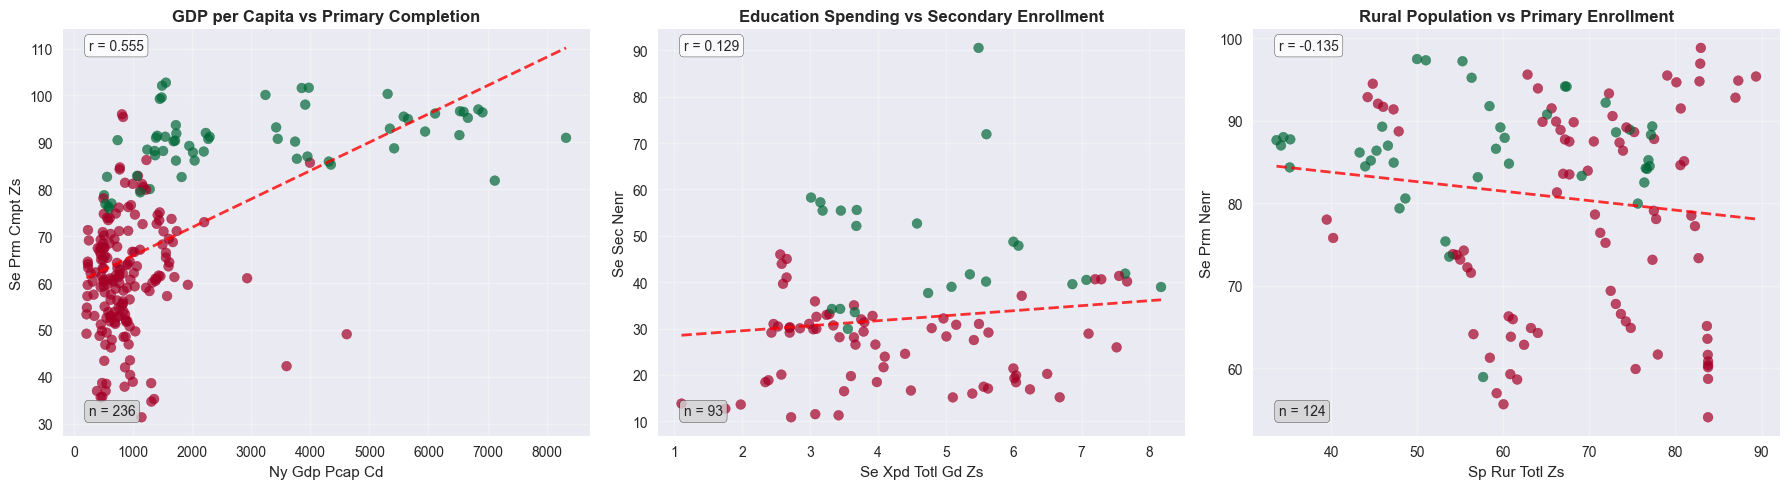


Data Availability Summary (using ALL data points):
GDP per Capita vs Primary Completion: 236/405 valid data points (58.3%)
Education Spending vs Secondary Enrollment: 93/405 valid data points (23.0%)
Rural Population vs Primary Enrollment: 124/405 valid data points (30.6%)

ALTERNATIVE ANALYSIS WITH MORE AVAILABLE INDICATORS
GDP per Capita vs Primary Enrollment: 124 data points available
Rural Population vs Primary Completion: 237 data points available


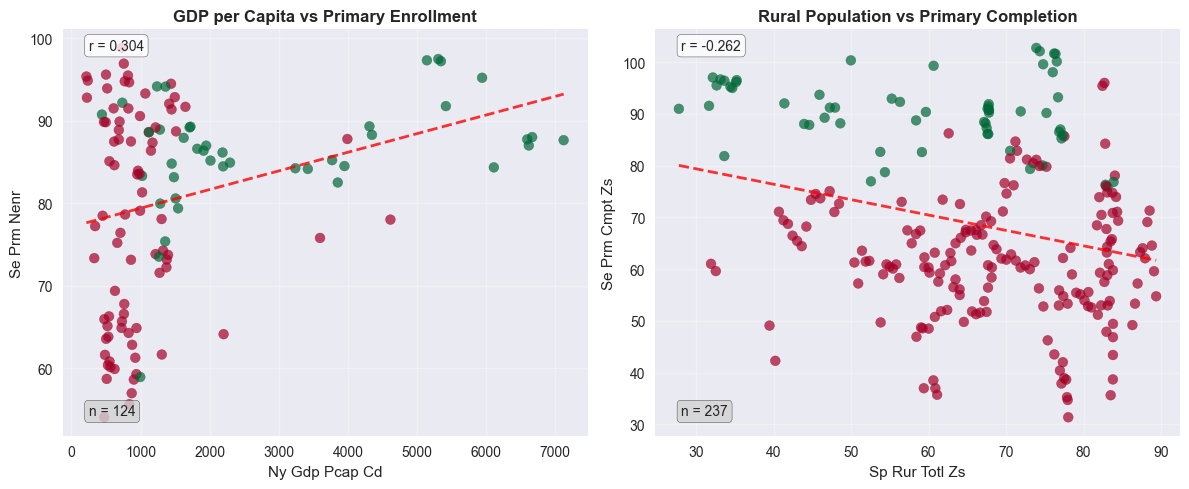

In [23]:
print("Available columns in the dataset:")
economic_cols = [col for col in features_df.columns if any(keyword in col.lower() for keyword in ['gdp', 'economic', 'income', 'poverty', 'rural', 'urban', 'spending', 'expenditure'])]
print("Economic-related columns:")
for col in economic_cols:
    print(f"  - {col}")

print("\nEducation-related columns:")
education_cols = [col for col in features_df.columns if any(keyword in col.lower() for keyword in ['education', 'school', 'enrollment', 'completion', 'literacy', 'primary', 'secondary'])]
for col in education_cols:
    print(f"  - {col}")

# Updated economic indicators vs education outcomes with available columns
economic_education_pairs = [
    ('NY.GDP.PCAP.CD', 'SE.PRM.CMPT.ZS', 'GDP per Capita vs Primary Completion'),
    ('SE.XPD.TOTL.GD.ZS', 'SE.SEC.NENR', 'Education Spending vs Secondary Enrollment'),
    ('SP.RUR.TOTL.ZS', 'SE.PRM.NENR', 'Rural Population vs Primary Enrollment')
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (x_var, y_var, title) in enumerate(economic_education_pairs):
    if x_var in features_df.columns and y_var in features_df.columns:
        # Use ALL available data points, not just latest year
        valid_data = features_df.dropna(subset=[x_var, y_var])
        
        # Check if we have enough data points
        if len(valid_data) > 1:
            # Create scatter plot
            scatter = axes[i].scatter(valid_data[x_var], valid_data[y_var], 
                                    c=valid_data['dropout_risk_high'] if 'dropout_risk_high' in valid_data.columns else 'blue',
                                    cmap='RdYlGn_r', alpha=0.7, s=50)
            
            # Set labels and title
            axes[i].set_xlabel(x_var.replace('_', ' ').replace('.', ' ').title())
            axes[i].set_ylabel(y_var.replace('_', ' ').replace('.', ' ').title())
            axes[i].set_title(title, fontsize=12, fontweight='bold')
            axes[i].grid(True, alpha=0.3)
            
            # Add trend line only if we have enough points
            if len(valid_data) >= 2:
                try:
                    z = np.polyfit(valid_data[x_var], valid_data[y_var], 1)
                    p = np.poly1d(z)
                    x_trend = np.linspace(valid_data[x_var].min(), valid_data[x_var].max(), 100)
                    axes[i].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
                    
                    # Calculate and display correlation
                    correlation = valid_data[x_var].corr(valid_data[y_var])
                    axes[i].text(0.05, 0.95, f'r = {correlation:.3f}', 
                               transform=axes[i].transAxes, fontsize=10,
                               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
                except Exception as e:
                    print(f"Could not fit trend line for {title}: {e}")
            
            # Add data point count
            axes[i].text(0.05, 0.05, f'n = {len(valid_data)}', 
                       transform=axes[i].transAxes, fontsize=10,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        else:
            # Handle case with insufficient data
            axes[i].text(0.5, 0.5, f'Insufficient data\nfor {title}', 
                       transform=axes[i].transAxes, ha='center', va='center',
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcoral", alpha=0.7))
            axes[i].set_xlabel(x_var.replace('_', ' ').replace('.', ' ').title())
            axes[i].set_ylabel(y_var.replace('_', ' ').replace('.', ' ').title())
            axes[i].set_title(title, fontsize=12, fontweight='bold')
    else:
        # Handle missing columns
        missing_cols = [col for col in [x_var, y_var] if col not in features_df.columns]
        axes[i].text(0.5, 0.5, f'Missing columns:\n{", ".join(missing_cols)}', 
                   transform=axes[i].transAxes, ha='center', va='center',
                   fontsize=12, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcoral", alpha=0.7))
        axes[i].set_title(title, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print data availability summary
print("\nData Availability Summary (using ALL data points):")
print("=" * 50)
for x_var, y_var, title in economic_education_pairs:
    if x_var in features_df.columns and y_var in features_df.columns:
        valid_count = features_df.dropna(subset=[x_var, y_var]).shape[0]
        total_count = features_df.shape[0]
        print(f"{title}: {valid_count}/{total_count} valid data points ({valid_count/total_count*100:.1f}%)")
    else:
        missing_cols = [col for col in [x_var, y_var] if col not in features_df.columns]
        print(f"{title}: Missing columns - {', '.join(missing_cols)}")

# Let's also try some alternative economic indicators that might be more available
print("\n" + "="*60)
print("ALTERNATIVE ANALYSIS WITH MORE AVAILABLE INDICATORS")
print("="*60)

# Check for alternative indicators
alternative_pairs = []

# Try to find better economic indicators
if 'NY.GDP.PCAP.CD' in features_df.columns:
    alternative_pairs.append(('NY.GDP.PCAP.CD', 'SE.PRM.NENR', 'GDP per Capita vs Primary Enrollment'))
if 'SP.RUR.TOTL.ZS' in features_df.columns:
    alternative_pairs.append(('SP.RUR.TOTL.ZS', 'SE.PRM.CMPT.ZS', 'Rural Population vs Primary Completion'))
if 'SP.URB.TOTL.IN.ZS' in features_df.columns:
    alternative_pairs.append(('SP.URB.TOTL.IN.ZS', 'SE.SEC.NENR', 'Urban Population vs Secondary Enrollment'))

if alternative_pairs:
    fig, axes = plt.subplots(1, len(alternative_pairs), figsize=(6*len(alternative_pairs), 5))
    if len(alternative_pairs) == 1:
        axes = [axes]
    
    for i, (x_var, y_var, title) in enumerate(alternative_pairs):
        if x_var in features_df.columns and y_var in features_df.columns:
            # Use ALL available data points
            valid_data = features_df.dropna(subset=[x_var, y_var])
            
            if len(valid_data) > 1:
                # Create scatter plot
                scatter = axes[i].scatter(valid_data[x_var], valid_data[y_var], 
                                        c=valid_data['dropout_risk_high'] if 'dropout_risk_high' in valid_data.columns else 'blue',
                                        cmap='RdYlGn_r', alpha=0.7, s=50)
                
                # Set labels and title
                axes[i].set_xlabel(x_var.replace('_', ' ').replace('.', ' ').title())
                axes[i].set_ylabel(y_var.replace('_', ' ').replace('.', ' ').title())
                axes[i].set_title(title, fontsize=12, fontweight='bold')
                axes[i].grid(True, alpha=0.3)
                
                # Add trend line
                if len(valid_data) >= 2:
                    try:
                        z = np.polyfit(valid_data[x_var], valid_data[y_var], 1)
                        p = np.poly1d(z)
                        x_trend = np.linspace(valid_data[x_var].min(), valid_data[x_var].max(), 100)
                        axes[i].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
                        
                        # Calculate and display correlation
                        correlation = valid_data[x_var].corr(valid_data[y_var])
                        axes[i].text(0.05, 0.95, f'r = {correlation:.3f}', 
                                   transform=axes[i].transAxes, fontsize=10,
                                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
                    except Exception as e:
                        print(f"Could not fit trend line for {title}: {e}")
                
                # Add data point count
                axes[i].text(0.05, 0.05, f'n = {len(valid_data)}', 
                           transform=axes[i].transAxes, fontsize=10,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
                
                print(f"{title}: {len(valid_data)} data points available")
    
    plt.tight_layout()
    plt.show()


**Key Findings**

1. **GDP per Capita vs Primary Enrollment (Left Plot)**
Sample size: 124 data points
Correlation: r = 0.304 (moderate positive correlation)
Interpretation: Countries with higher GDP per capita tend to have higher primary school enrollment rates
Trend: The red dashed line shows a clear upward trend - as economic prosperity increases, more children attend primary school

2. **Rural Population vs Primary Completion (Right Plot)**
Sample size: 237 data points (much larger sample!)
Correlation: r = -0.262 (moderate negative correlation)
Interpretation: Countries with higher rural population percentages tend to have lower primary school completion rates
Trend: The downward trend suggests that rural areas face challenges in ensuring children complete their primary education

**Green dots:** Lower dropout risk

**Red dots:** Higher dropout risk

**Policy Implications**

These findings suggest:

Economic development is positively associated with education access
Rural-urban disparities significantly impact educational completion
Countries should focus on rural education infrastructure and support systems

Economic growth strategies should consider their impact on educational outcomes

## 8. Key Insights and Findings Summary

In [24]:
# Generate comprehensive insights summary
print("=" * 80)
print("KEY INSIGHTS FROM AFRICAN EDUCATION DROPOUT ANALYSIS")
print("=" * 80)

# 1. Regional patterns
if 'SE.PRM.NENR' in features_df.columns:
    regional_primary = features_df.groupby('region')['SE.PRM.NENR'].mean().sort_values(ascending=False)
    print("\n1. REGIONAL PRIMARY ENROLLMENT PATTERNS:")
    for region, rate in regional_primary.items():
        if pd.notna(rate):
            print(f"   {region}: {rate:.1f}% average enrollment")

# 2. Gender disparities
if 'primary_gender_parity' in features_df.columns:
    gender_parity = features_df['primary_gender_parity'].mean()
    print(f"\n2. GENDER PARITY:")
    print(f"   Primary education gender parity index: {gender_parity:.2f}")
    print(f"   {'Female advantage' if gender_parity > 1 else 'Male advantage' if gender_parity < 1 else 'Gender parity'}")

# 3. Dropout risk distribution
if 'dropout_risk_high' in features_df.columns:
    high_risk_pct = features_df['dropout_risk_high'].mean() * 100
    print(f"\n3. DROPOUT RISK ASSESSMENT:")
    print(f"   {high_risk_pct:.1f}% of country-years classified as high dropout risk")
    
    # Countries with highest risk
    country_risk = features_df.groupby('country_name')['dropout_risk_high'].mean().sort_values(ascending=False)
    print(f"\n   TOP 5 HIGHEST RISK COUNTRIES:")
    for i, (country, risk) in enumerate(country_risk.head().items()):
        print(f"   {i+1}. {country}: {risk*100:.1f}% of years high risk")

# 4. Economic correlations
if 'NY.GDP.PCAP.CD' in features_df.columns and 'SE.PRM.CMPT.ZS' in features_df.columns:
    correlation = features_df[['NY.GDP.PCAP.CD', 'SE.PRM.CMPT.ZS']].corr().iloc[0,1]
    print(f"\n4. ECONOMIC FACTORS:")
    print(f"   GDP per capita vs Primary completion correlation: {correlation:.3f}")

print("\n" + "=" * 80)
print("RECOMMENDATIONS FOR POLICY MAKERS:")
print("=" * 80)
print("1. Focus interventions on regions with lowest enrollment rates")
print("2. Address gender disparities through targeted programs")
print("3. Prioritize high-risk countries for international support")
print("4. Strengthen economic development alongside education investment")
print("5. Implement early warning systems for dropout prevention")
print("=" * 80)

KEY INSIGHTS FROM AFRICAN EDUCATION DROPOUT ANALYSIS

1. REGIONAL PRIMARY ENROLLMENT PATTERNS:
   Southern Africa: 89.3% average enrollment
   East Africa: 87.7% average enrollment
   Central Africa: 79.5% average enrollment
   West Africa: 69.7% average enrollment

2. GENDER PARITY:
   Primary education gender parity index: 0.96
   Male advantage

3. DROPOUT RISK ASSESSMENT:
   45.2% of country-years classified as high dropout risk

   TOP 5 HIGHEST RISK COUNTRIES:
   1. Burkina Faso: 93.3% of years high risk
   2. Cameroon: 93.3% of years high risk
   3. Madagascar: 93.3% of years high risk
   4. Niger: 93.3% of years high risk
   5. Mozambique: 80.0% of years high risk

4. ECONOMIC FACTORS:
   GDP per capita vs Primary completion correlation: 0.555

RECOMMENDATIONS FOR POLICY MAKERS:
1. Focus interventions on regions with lowest enrollment rates
2. Address gender disparities through targeted programs
3. Prioritize high-risk countries for international support
4. Strengthen economic 

## 9. Data Export for Modeling

Prepare cleaned datasets for machine learning model development.

In [25]:
# Export cleaned data for modeling
modeling_data = features_df.copy()

# Remove rows with too many missing values
modeling_data = modeling_data.dropna(thresh=len(modeling_data.columns) * 0.5)

# Save modeling dataset
modeling_data.to_csv('data/processed/modeling_dataset.csv', index=False)
print(f"Modeling dataset saved: {len(modeling_data)} records")
print(f"Features available: {len(modeling_data.columns)} columns")
print("\nReady for machine learning model development!")

Modeling dataset saved: 226 records
Features available: 38 columns

Ready for machine learning model development!
